<a href="https://colab.research.google.com/github/duartegonzaloariel/UDELAR_FireBall/blob/main/UDELAR_FB_Resultados_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fireball Project**
---
*Project:  Fireball Core*

*Author:  Juan Ramon Diaz Santos, Gonzalo Duarte*

*Source:   BOCOSUR*

*Version:  1.0*

*Date:     20/09/2024*

## **RESULTS DATA ANALYSIS**

1. [Initialization](#initialization)
   - 1.1. [Libraries](#Libraries)
   - 1.2. [Collab initialization](#Collab-initialization)
   - 1.3. [Configuration](#Configuration)
   - 1.4. [Auxiliar Functions](#Functions)
   - 1.5. [Load Data](#Load-Data)
2. [Results Analysis](#Results-Analysis)
   - 2.1. [Prediction Histogram](#Prediction-Histogram)
   - 2.2. [Reduction Dimension Analysis](#Reduction-Dimension-Analysis)
   - 2.3. [Clustering-Analysis](#Clustering-Analysis)
   - 2.4. [Confidence Boxplot](#confidence-boxplot)
   - 2.5. [Confussion Matrix](#Confussion-Matrix)
   - 2.6. [Curva ROC](#Curva-ROC)
3. [Machine Learning](#Machine-Learning)

# **Initialization**
---
En esta sección se cargan las librerias de Python requeridas y se definen los parémtros de configuración y funciones  necesarias para realizar el análisis de los datos
1. [Libraries](#Libraries)
2. [Collab initialization](#Collab-initialization)
3. [Configuration](#Configuration)
4. [Auxiliar Functions](#Functions)
5. [Load Data](#Load-Data)

## Libraries

In [ ]:
###############################################################################
###############################################################################
#                              LIBRERIAS
###############################################################################
###############################################################################

# Standar Python Libraries
#______________________________________________________________________________
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# SKLEARN Libraries
#______________________________________________________________________________
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Complementary libraries
#______________________________________________________________________________
from imblearn.over_sampling import SMOTE


## Collab Initialization

In [ ]:
###############################################################################
###############################################################################
#                    Collab Initialization
###############################################################################
###############################################################################

# Determina si el script se ejecuta en Collab o en Jupyter Notebok
#______________________________________________________________________________
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')
    COLLAB = True
    path_system = '/content/drive/My Drive/InvestigacionesPropias/'
except ImportError:
    COLLAB = False
    path_system =  os.path.dirname(os.path.dirname(os.getcwd()))

print("Notebook is running in Google Colab:", COLLAB)
print('System Path:', path_system)



Mounted at /content/drive
Notebook is running in Google Colab: True
System Path: /content/drive/My Drive/InvestigacionesPropias/


## Functions

In [ ]:
###############################################################################
###############################################################################
#                              FUNCTIONS                                      #
###############################################################################
###############################################################################
#______________________________________________________________________________
#       Función de Normalización Uniforme en el rango [0,1]
#______________________________________________________________________________

def normalize(data):
    data = (data - np.min(data))/(np.max(data) - np.min(data))
    return data

#______________________________________________________________________________
#       Función Softmax
#           - Devuelve las probabilidades de cada categoria)
#           - Suma(X[i]) = 1
#______________________________________________________________________________
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

## Configuration


In [ ]:
###############################################################################
###############################################################################
#                              CONFIGURACION                                  #
###############################################################################
###############################################################################
# PATHS
DATABASE = 'Watec-ASI'
RESOLUTION = ''

filename_model = ''.join(['modelo_',DATABASE,RESOLUTION])#cambiar 83
filename_training = ''.join([DATABASE,RESOLUTION])
filename_prediction_csv = ''.join([DATABASE, '_modelo_',DATABASE, '_prediccion',RESOLUTION])#cambiar 83
filename_prediction_bolidos_csv = ''.join([DATABASE, '_modelo_',DATABASE,
                                           '_prediccion_bolidos_entrenamiento_', DATABASE,RESOLUTION])

training = ''.join(['entrenamiento_', DATABASE])
test     = ''.join(['MC_', DATABASE])

path_base = os.path.join(path_system,'Fireball')
path_results = os.path.join(path_base, 'Resultados')

path_database       = os.path.join(path_results, training)
path_model          = os.path.join(path_database, f'{filename_model}.h5')
path_datatrain      = os.path.join(path_database, training)


##  PREDICCIONES
path_predictions            = os.path.join(path_results, 'Predicciones')
path_prediction_csv         = os.path.join(path_predictions,
                                          f'{filename_prediction_csv}.csv')
path_prediction_bolidos_csv = os.path.join(path_predictions,
                                           f'{filename_prediction_bolidos_csv}.csv')
path_dataprediction = os.path.join(path_predictions, DATABASE )


path_filetrain      = os.path.join(path_database,
                                   f'{filename_training}.csv')

#______________________________________________________________________________
# System Configuration
#______________________________________________________________________________
data_type = DATABASE
NORM      = 'softmax'
df_target_field = 'target'

#______________________________________________________________________________
# Configuración
#______________________________________________________________________________
image_size = (224, 224)
n_classes = 6
TARGET = True

#______________________________________________________________________________
# t-SNE y PCA Configuration
#______________________________________________________________________________
N_COMPONENTS  = 2
PERPLEXITY    = 30
MAX_ITER      = 2000



#______________________________________________________________________________
print('PATH Information:')
print('\t- Path System:         \t', path_system)
print('\t- Path Project:        \t', path_base)
print('\t- Path Results:        \t', path_results)
print('\t- Path Database:       \t', path_database)
print('\t- Path Model Filename: \t', path_model)
print('\t- Path Predictions:    \t', path_predictions)
print('\t- Path Prediction File:\t', path_prediction_csv)
print('\t- Path Data Prediction:\t', path_dataprediction)
print('\t- Path Bolidos Prediction File:\t', path_prediction_bolidos_csv)
print('\t- Path Training Results File  :\t', path_filetrain)

files = os.listdir(path_predictions)
print('\nList of Predictions Files Stored in Google Drive')
for ix, file in enumerate(files):
    print('\t', ix+1,':',file)

print('\nSystem Configuration')
print('\t- Data type: \t', data_type)
print('\t- Image Size:\t', image_size)
print('\t- N Classes: \t', n_classes)


PATH Information:
	- Path System:         	 /content/drive/My Drive/InvestigacionesPropias/
	- Path Project:        	 /content/drive/My Drive/InvestigacionesPropias/Fireball
	- Path Results:        	 /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados
	- Path Database:       	 /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/entrenamiento_Watec-ASI
	- Path Model Filename: 	 /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/entrenamiento_Watec-ASI/modelo_Watec-ASI.h5
	- Path Predictions:    	 /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/Predicciones
	- Path Prediction File:	 /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/Predicciones/Watec-ASI_modelo_Watec-ASI_prediccion.csv
	- Path Data Prediction:	 /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/Predicciones/Watec-ASI
	- Path Bolidos Prediction File:	 /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/Predicci

## Load Data

In [ ]:
###############################################################################
###############################################################################
#      Load Prediction Data
###############################################################################
###############################################################################

#__________________________________________________________________________
#         IMPORTA ARCHIVO DE DATOS DE RESULTADOS                         #
#__________________________________________________________________________
def load_prediction_csv(df_filename, classes):
    df_prediction = pd.read_csv(df_filename)
    output = []
    target = []

    for i in range(n_classes):
        output.append(np.array(df_prediction[f'Porcentaje de Clase {i+1}']))

    output = np.array(output).transpose(1,0)
    target = np.array(target)
    print('\n\t- Output Prediction Shape:', output.shape)
    print('\t- Target Shape:', target.shape)

    print('\n\t-  Original Data Shape:',output.shape,
          '\n\t--> Data 0:', output[0])
    if NORM == 'softmax':
        output = softmax(output)
    if NORM == 'uniform':
        output = normalize(output)
    print('\n\t-  Normalizaed Data Shape:',output.shape,
          '\n\t--> Data 0:', output[0], '\n')

    if TARGET:
        target = np.array(df_prediction[df_target_field], dtype = int)
    else:
        target = np.zeros(output.shape[0], dtype = int)

    print('\nTARGET shape:\t',target.shape)
    return output, target


classes = []
for i in range(n_classes):
    classes.append(''.join(['Clase ',str(i+1)]))

print('\nPREDICTION FILE:',path_prediction_csv)
output_prediction, target_prediction = load_prediction_csv(path_prediction_csv,
                                                          classes = n_classes)

print('\nCLASSES:\t',classes)
output_clase = []
target_clase = []
for clase in range(n_classes):
    output_clase.append(output_prediction[target_prediction == clase])
    target_clase.append(5 * np.ones(len(output_clase[clase])))
    print('\nCLASS', clase, ':\t', output_clase[clase].shape, target_clase[clase].shape)



PREDICTION FILE: /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/Predicciones/Watec-ASI_modelo_Watec-ASI_prediccion.csv

	- Output Prediction Shape: (1349, 6)
	- Target Shape: (0,)

	-  Original Data Shape: (1349, 6) 
	--> Data 0: [76.04347992  4.26440668  6.0538044   8.85143757  1.40043676  3.3864367 ]

	-  Normalizaed Data Shape: (1349, 6) 
	--> Data 0: [1.00000000e+00 6.71034079e-32 4.01670679e-31 6.58971723e-30
 3.82770309e-33 2.78899065e-32] 


TARGET shape:	 (1349,)

CLASSES:	 ['Clase 1', 'Clase 2', 'Clase 3', 'Clase 4', 'Clase 5', 'Clase 6']

CLASS 0 :	 (372, 6) (372,)

CLASS 1 :	 (36, 6) (36,)

CLASS 2 :	 (60, 6) (60,)

CLASS 3 :	 (188, 6) (188,)

CLASS 4 :	 (396, 6) (396,)

CLASS 5 :	 (297, 6) (297,)



Path: /content/drive/My Drive/InvestigacionesPropias/Fireball/Resultados/Predicciones/Watec-ASI


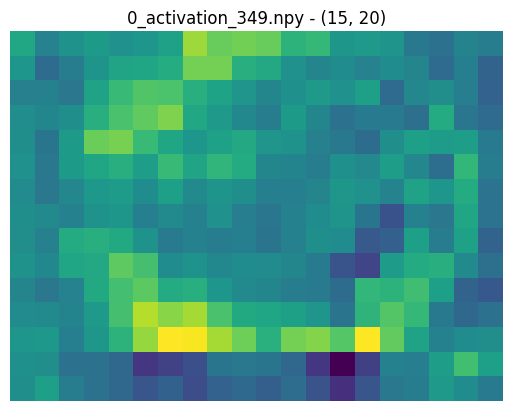

Classe 0 -> (372, 15, 20)
Classe 1 -> (36, 15, 20)
Classe 2 -> (60, 15, 20)
Classe 3 -> (188, 15, 20)
Classe 4 -> (396, 15, 20)
Classe 5 -> (297, 15, 20)
(372, 15, 20) -1.1903507709503174 0.5559614300727844 -0.3634805188997207
(36, 15, 20) -0.6734222769737244 0.19654375314712524 -0.30308400105120165
(60, 15, 20) -0.7940962910652161 0.4955500364303589 -0.3690803835161625
(188, 15, 20) -1.0099159479141235 0.9073449373245239 -0.35454588445132196
(396, 15, 20) -1.2661423683166504 0.8598877191543579 -0.3600977266462256
(297, 15, 20) -0.9632341265678406 0.9426286816596985 -0.3705542046823876

data_activa_flat shape (1349, 300) 

[0, 372, 408, 468, 656, 1052, 1349]
data_clase_flat shape 0 : (372, 300)
data_clase_flat shape 1 : (36, 300)
data_clase_flat shape 2 : (60, 300)
data_clase_flat shape 3 : (188, 300)
data_clase_flat shape 4 : (396, 300)
data_clase_flat shape 5 : (297, 300)


In [ ]:
# LOAD ACTIVATION IMAGES
def load_activation(path):

    boolshow = True
    npy_files_clases = []
    for classe in range(n_classes):
        npy_files_clases.append([f for f in os.listdir(path) if f.endswith('.npy') and f.startswith(str(classe))])
    file_path = os.path.join(path, npy_files_clases[0][0])
    data_file = np.load(file_path)
    plt.imshow(data_file)
    plt.axis('off')  # Ocultar los ejes
    plt.title(''.join([npy_files_clases[0][0], ' - ', str(data_file.shape)]))
    plt.show()

    data_list = []

    for classe in range(n_classes):
        data = np.zeros((len(npy_files_clases[classe]), data_file.shape[0], data_file.shape[1]))

        for i, npy_file in enumerate(npy_files_clases[classe]):
            file_path = os.path.join(path, npy_files_clases[classe][i])
            data[i] = np.load(file_path)
        data_list.append(data)
        print('Classe', classe, '->', data.shape)

    return data_list

print('\nPath:', path_dataprediction)
data_activa = load_activation(path_dataprediction)

for classe in range(n_classes):
  if len(data_activa[classe])>0:
    print(data_activa[classe].shape, data_activa[classe].min(), data_activa[classe].max(), data_activa[classe].mean())

data_activa_conc = np.concatenate(data_activa, axis=0)
shape = data_activa_conc.shape
data_activa_flat = data_activa_conc.reshape(shape[0], shape[1] * shape[2])
print('\ndata_activa_flat shape', data_activa_flat.shape, '\n')


data_clase_flat  = []
index_class = [0]
for classe in range(n_classes):
    shape = data_activa[classe].shape
    data_clase_flat.append( data_activa[classe].reshape(shape[0], shape[1] * shape[2]))
    index_class.append(index_class[classe] + len(data_activa[classe]))
print(index_class)
for classe in range(len(data_clase_flat)):
    print('data_clase_flat shape', classe,':', data_clase_flat[classe].shape)

In [ ]:
npy_files_clases = []
for classe in range(n_classes):
    npy_files_clases.append([f for f in os.listdir(path_dataprediction) if f.endswith('.npy') and f.startswith(str(classe))])



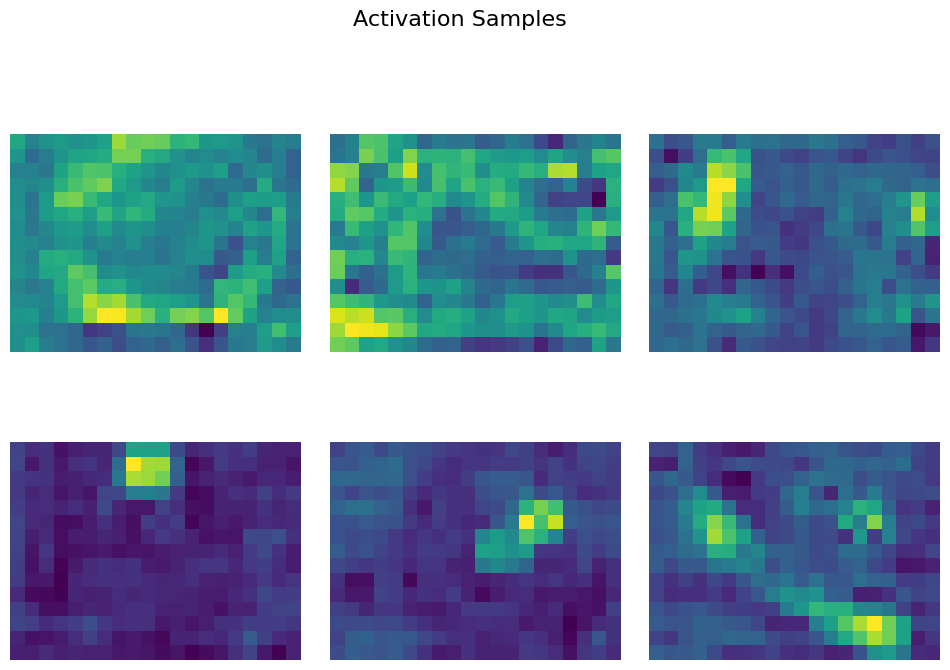

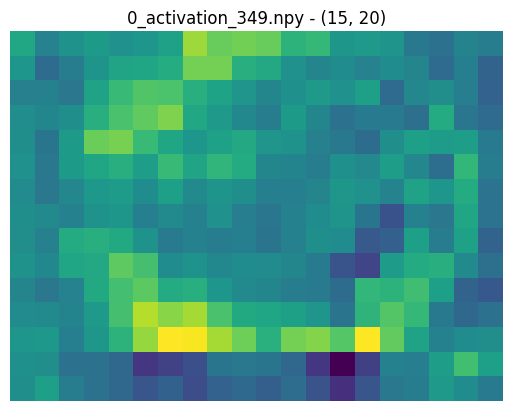

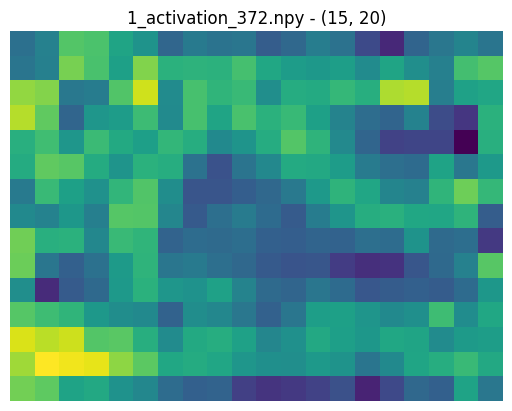

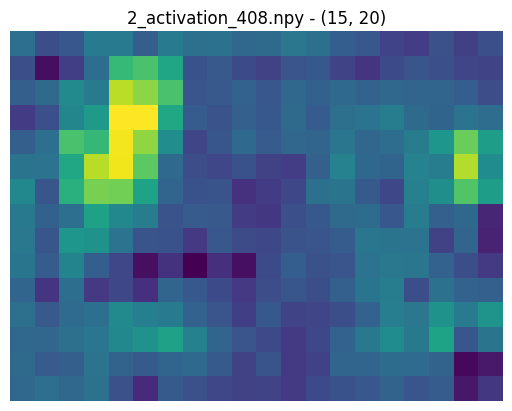

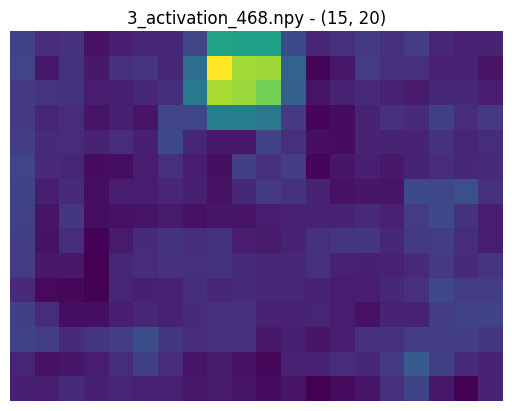

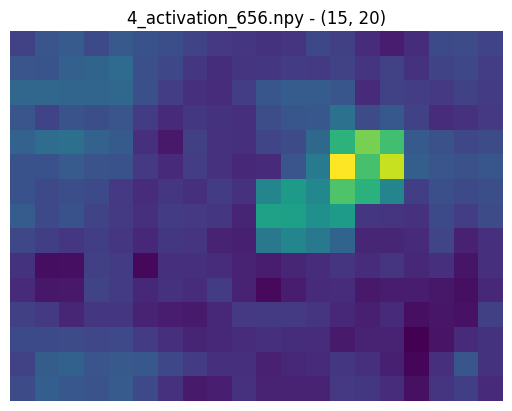

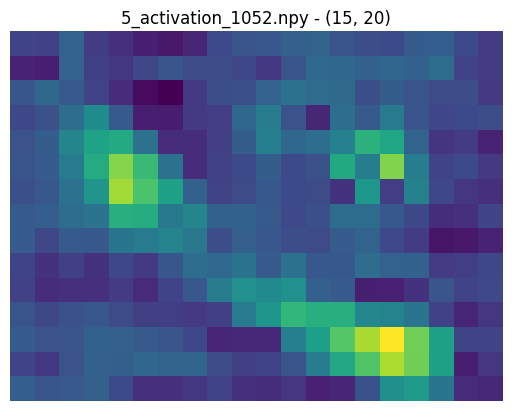

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    file_path = os.path.join(path_dataprediction, npy_files_clases[i][0])
    data_file = np.load(file_path)

    ax.imshow(data_file)
    ax.axis('off')  # Ocultar los ejes
    #ax.set_xticks([])  # Eliminar ejes X
   # ax.set_yticks([])
plt.subplots_adjust(wspace=0.1, hspace=0)  # Ajusta wspace para espacio horizontal y hspace para espacio vertical
fig.suptitle("Activation Samples", fontsize=16)
plt.show()

#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para que el título y la leyenda no se solapen



for i in range(n_classes):
    file_path = os.path.join(path_dataprediction, npy_files_clases[i][0])
    data_file = np.load(file_path)

    plt.imshow(data_file)
    plt.axis('off')  # Ocultar los ejes
    plt.title(''.join([npy_files_clases[i][0], ' - ', str(data_file.shape)]))
    plt.show()

# **Results Analysis**
---
## Analysis Performed
1. [Prediction Histogram](#Load-Data)
2. [Reduction Dimension Analysis](#Reduction-Dimension-Analysis)
3. [Clustering-Analysis](#Clustering-Analysis)
4. [Confidence Boxplot](#confidence-boxplot)
5. [Confussion Matrix](#Confussion-Matrix)
6. [Curva ROC](#Curva-ROC)

## TRAINING EVOLUTION

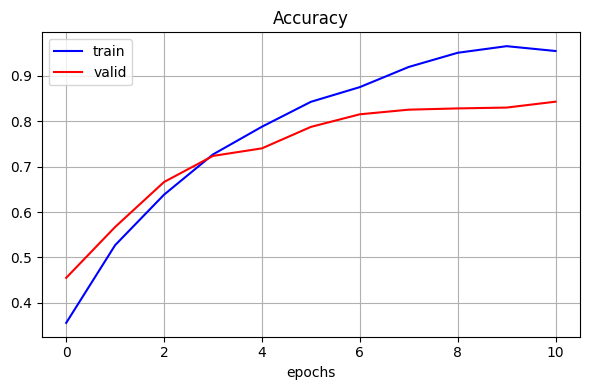

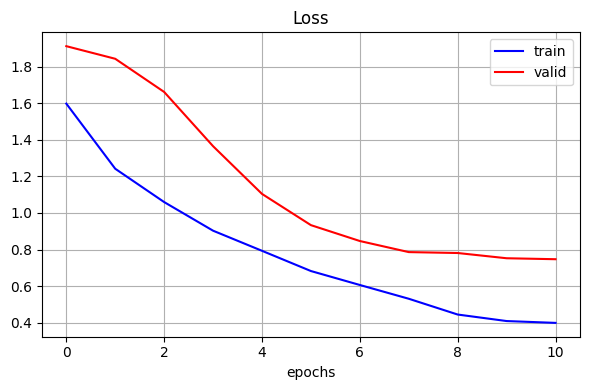

<Figure size 600x400 with 0 Axes>

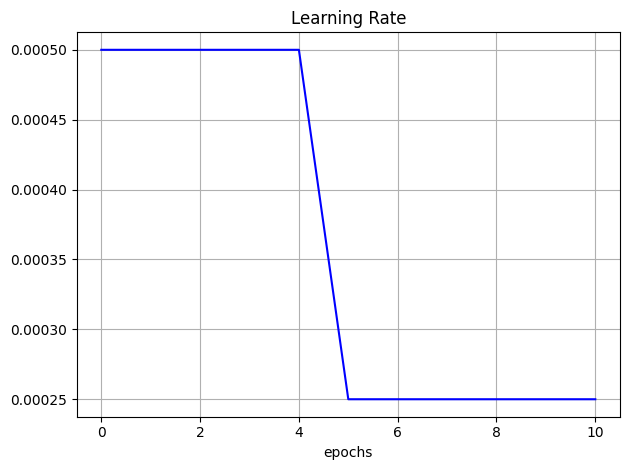

In [ ]:
df_training = pd.read_csv(path_filetrain)
train_accuracy = df_training['accuracy']
valid_accuracy = df_training['val_accuracy']
train_loss = df_training['loss']
valid_loss = df_training['val_loss']
lr = df_training['lr']

fig = plt.figure(figsize=(6, 4))

plt.plot(train_accuracy, label='train', c='b')
plt.plot(valid_accuracy, label='valid', c='r')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(6, 4))

plt.plot(train_loss, label='train', c='b')
plt.plot(valid_loss, label='valid', c='r')
plt.title('Loss')
plt.xlabel('epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()

fig = plt.figure(figsize=(6, 4))

plt.show()
plt.plot(lr,c='b')
plt.title('Learning Rate')
plt.xlabel('epochs')
plt.grid(True)
plt.tight_layout()
plt.show()

## Prediction-Histogram


HISTOGRAMA DE PREDICCIONES PARA EL CONJUNTO DE DATOS

Clase: 1 	Min: 1.4286389445592812e-42 	Max: 1.0 	Mean: 0.27371753426296686 	std dev: 0.44435656291472325 

Clase: 2 	Min: 3.0856673698599126e-42 	Max: 1.0 	Mean: 0.02743536785027095 	std dev: 0.1633251297005452 

Clase: 3 	Min: 1.7046079068326664e-42 	Max: 1.0 	Mean: 0.04241454910594894 	std dev: 0.20100841566371447 

Clase: 4 	Min: 1.328165494901263e-42 	Max: 1.0 	Mean: 0.16302374165971173 	std dev: 0.3684041466124625 

Clase: 5 	Min: 1.7687062263257152e-42 	Max: 1.0 	Mean: 0.27623048466171424 	std dev: 0.44616228997833696 

Clase: 6 	Min: 2.2119809634932727e-42 	Max: 1.0 	Mean: 0.21717832245938729 	std dev: 0.4119422348380658 



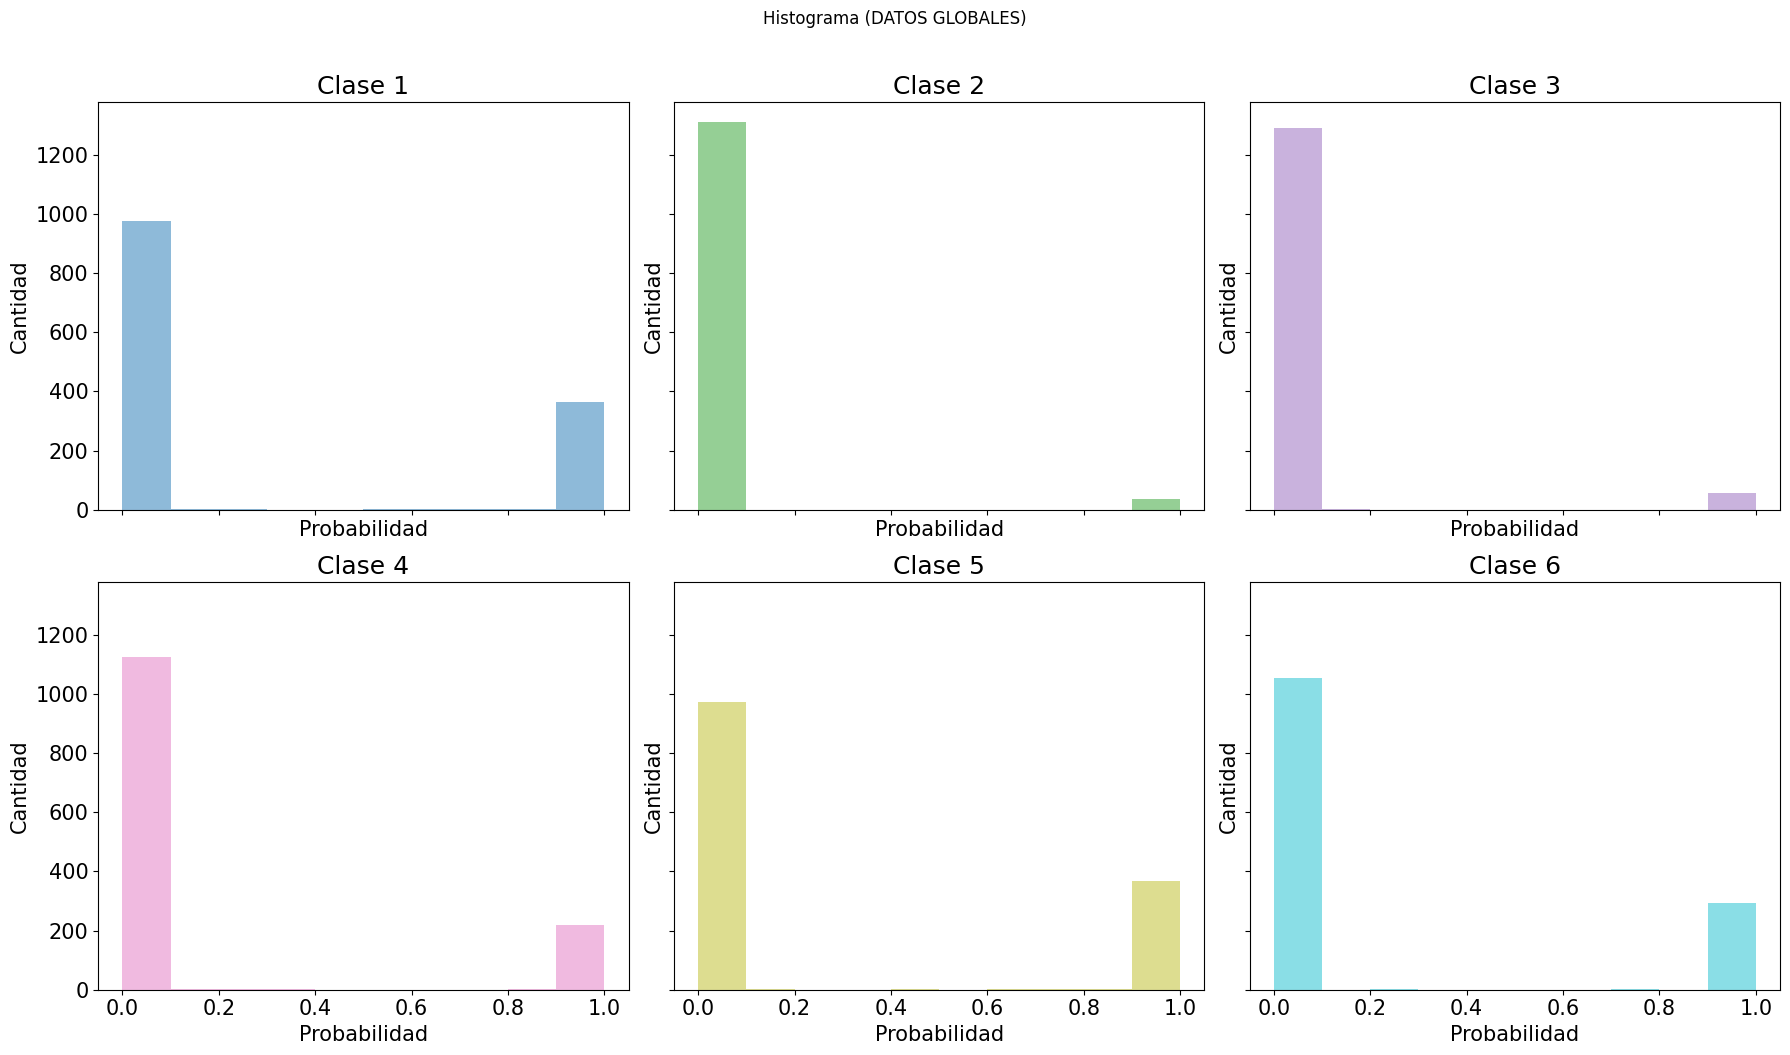


HISTOGRAMA DE PREDICCIONES PARA DATOS CLASIFICADOS COMO CLASE 6

Clase: 1 	Min: 3.965059020474064e-41 	Max: 1.0 	Mean: 0.05711032683643292 	std dev: 0.23123849657723738 

Clase: 2 	Min: 5.84432950621355e-41 	Max: 0.00037319362821879937 	Mean: 1.2643944134042686e-06 	std dev: 2.1618367794854233e-05 

Clase: 3 	Min: 4.857310681366019e-41 	Max: 0.015681870997954244 	Mean: 8.818518099668994e-05 	std dev: 0.0010387024711893636 

Clase: 4 	Min: 7.01640019683454e-41 	Max: 1.0 	Mean: 0.07516046358832876 	std dev: 0.26198903067741997 

Clase: 5 	Min: 4.10293329772711e-41 	Max: 1.0 	Mean: 0.05366074119621377 	std dev: 0.22490287387233002 

Clase: 6 	Min: 1.1114088041674913e-40 	Max: 1.0 	Mean: 0.8139790188036143 	std dev: 0.38819079709127335 



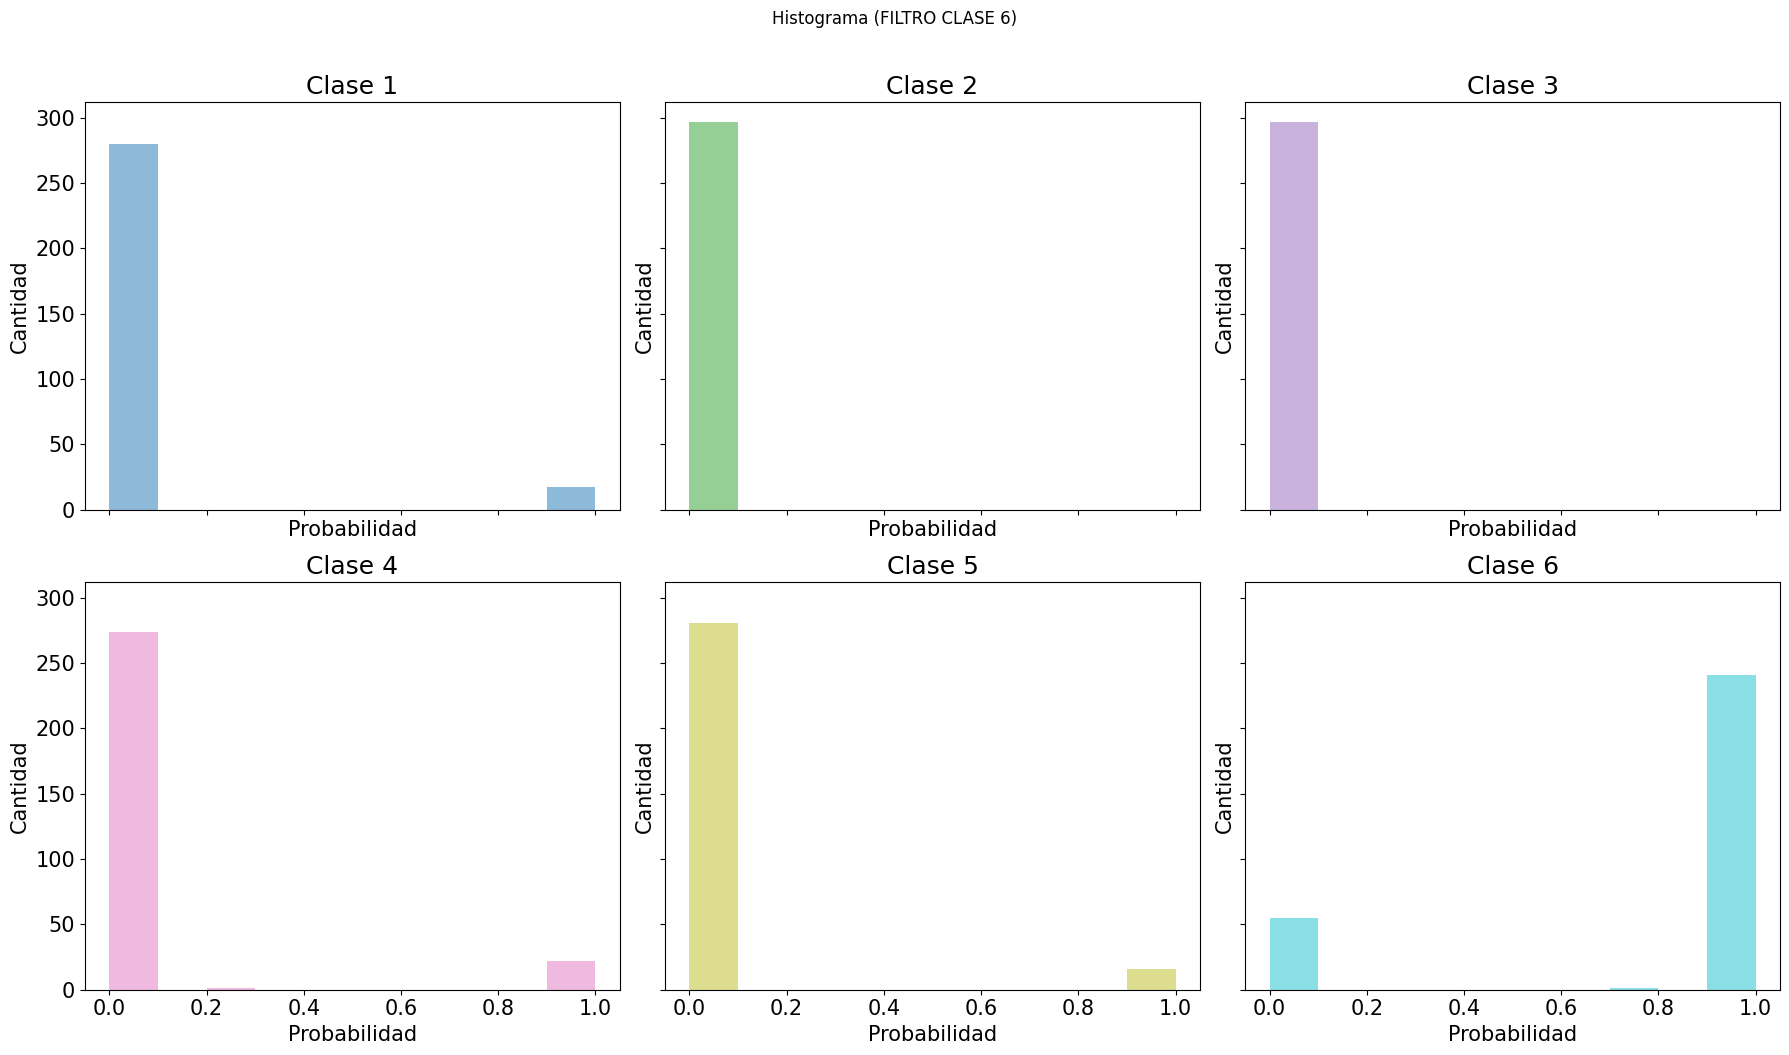

In [ ]:
###############################################################################
###############################################################################
#                     HISTOGRAM
###############################################################################
###############################################################################
def plot_Histogram(data, classes, title):
    #__________________________________________________________________________
    # Generar una lista de colores para n_clases
    #__________________________________________________________________________
    cmap = plt.get_cmap('tab10', classes)
    colors = cmap.colors.tolist()

    #__________________________________________________________________________
    # Crear subplots para cada clase en una matriz de 2x4
    #__________________________________________________________________________

    if classes == 6:
            fig, axs = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
    if classes == 1:
            plt.figure(figsize=(10, 6))

    #__________________________________________________________________________
    # Iterar sobre cada clase y dibujar el histograma correspondiente
    #__________________________________________________________________________
    for i in range(classes):
        data_plot = data[:,i]
        if classes == 6:
            row = i // 3
            col = i % 3
            ax = axs[row, col]
            ax.hist(data_plot, bins=10,  alpha=0.5, range=(0, 1), color=colors[i])
            ax.set_title(f'Clase {i+1}', fontsize=18)  # Tamaño del título
            ax.set_xlabel('Probabilidad', fontsize=15)  # Tamaño del nombre del eje x
            ax.set_ylabel('Cantidad', fontsize=15)  # Tamaño del nombre del eje y
            ax.tick_params(axis='both', which='major', labelsize=15)  # Ajustar el tamaño de las etiquetas de los ejes

        print('Clase:',i+1, '\tMin:', np.min(data_plot), '\tMax:',
              np.max(data_plot), '\tMean:', np.mean(data_plot), '\tstd dev:',
              np.std(data_plot),'\n')

    #__________________________________________________________________________
    # Ajustar automáticamente el espaciado entre subplots
    #__________________________________________________________________________
    plt.tight_layout()
    plt.suptitle(title, y = 1.05)
    #__________________________________________________________________________
    # Mostrar los subplots
    #__________________________________________________________________________
    plt.show()

print('\nHISTOGRAMA DE PREDICCIONES PARA EL CONJUNTO DE DATOS\n')
plot_Histogram(output_prediction,
               classes = n_classes,
               title = 'Histograma (DATOS GLOBALES)')
print('\nHISTOGRAMA DE PREDICCIONES PARA DATOS CLASIFICADOS COMO CLASE 6\n')
CLASSE = 5
plot_Histogram(output_clase[CLASSE],
               classes = n_classes,
               title = 'Histograma (FILTRO CLASE 6)')



## Reduction Dimension Analysis

 Performing PCA Analysis...
(1349,)
1 (372, 2) 0
0 372


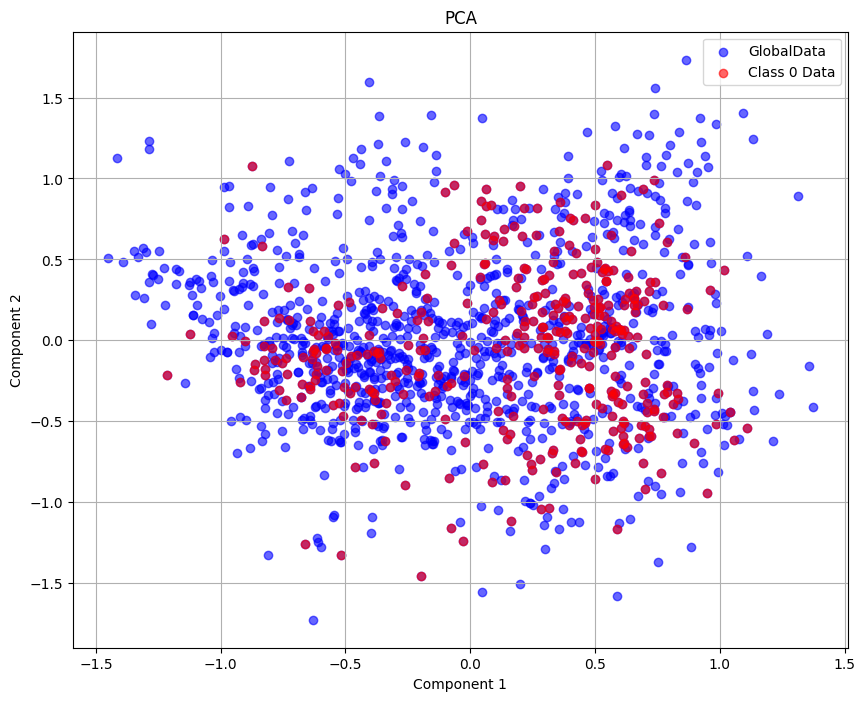

(1349,)
2 (36, 2) 1
372 408


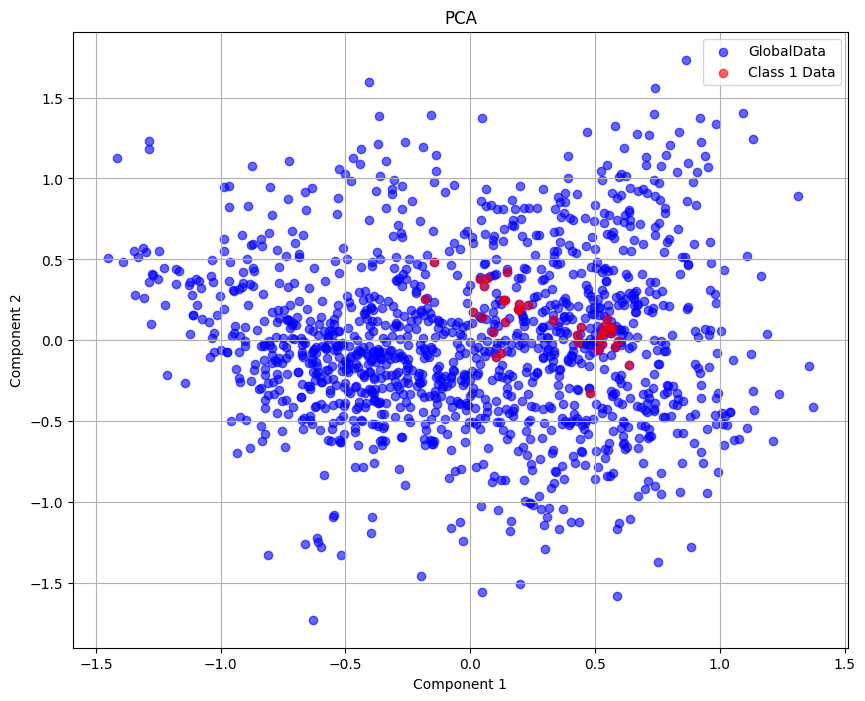

(1349,)
3 (60, 2) 2
408 468


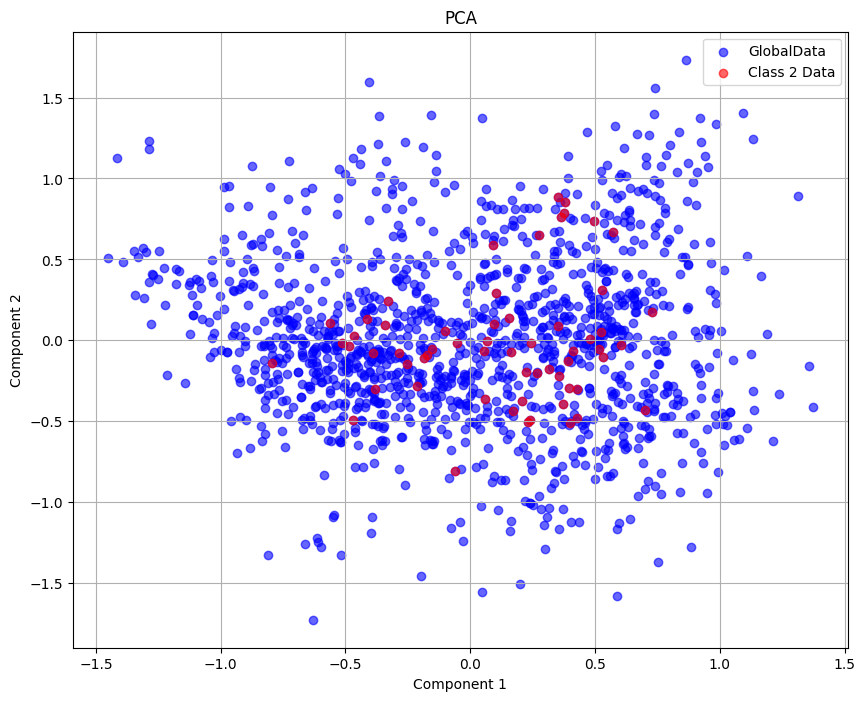

(1349,)
4 (188, 2) 3
468 656


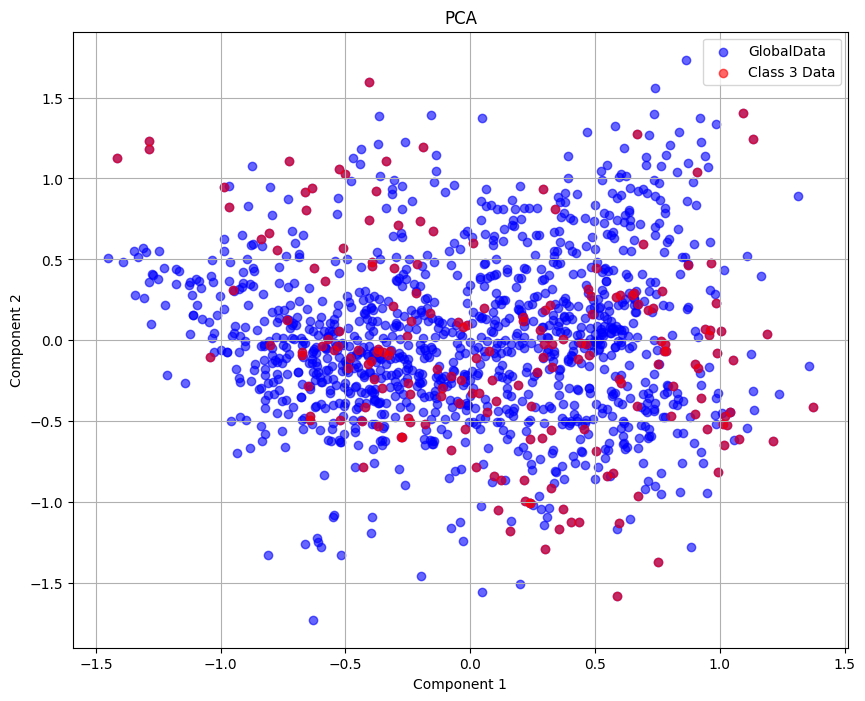

(1349,)
5 (396, 2) 4
656 1052


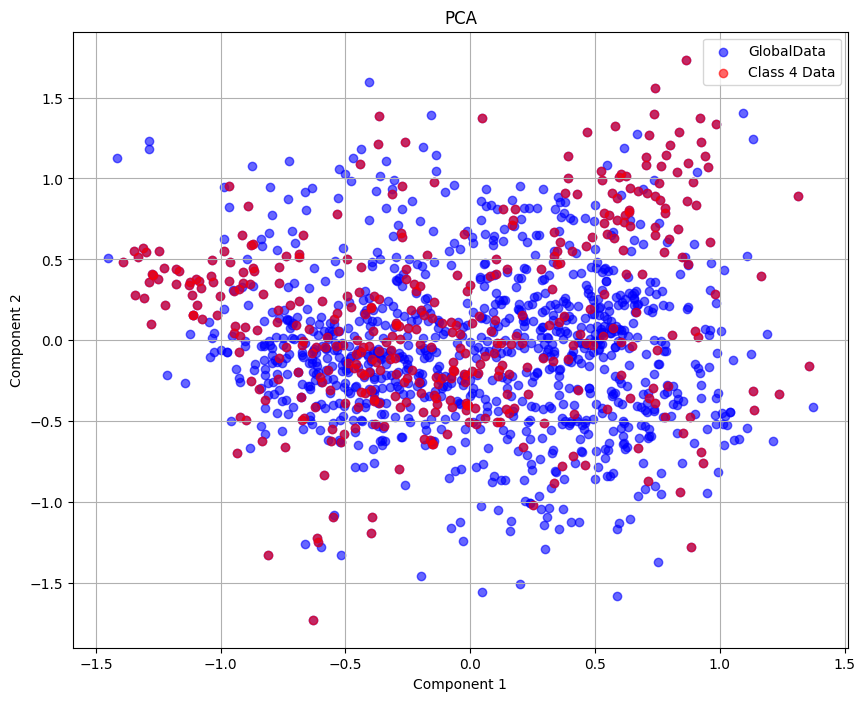

(1349,)
6 (297, 2) 5
1052 1349


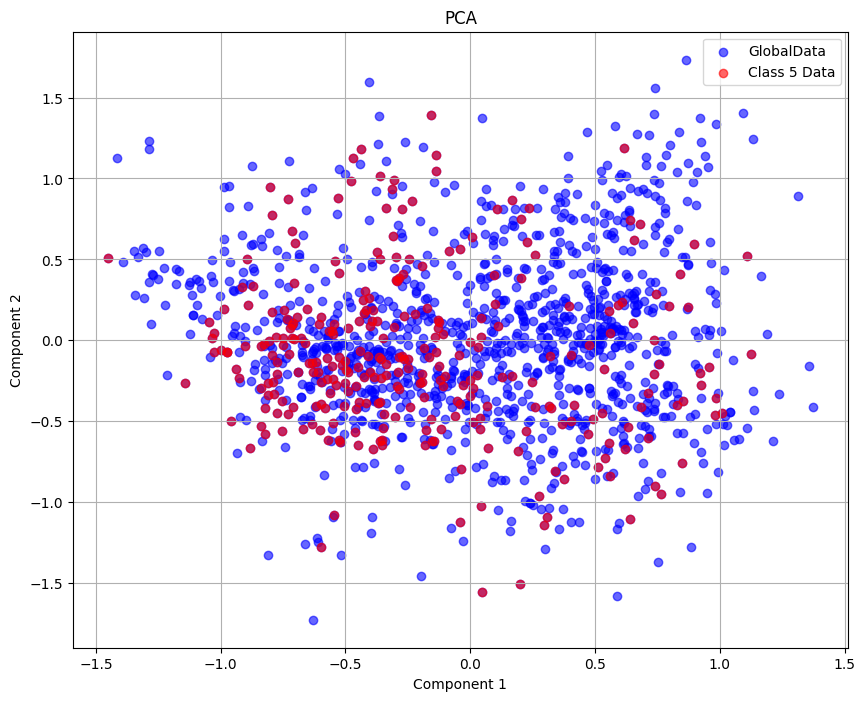

PCA Analysis Performed. Results PCA Shape: (1349, 2)
Data Shape: (1349, 6)  Performing t-SNE Analysis...
(1349,)
1 (372, 2) 0
0 372


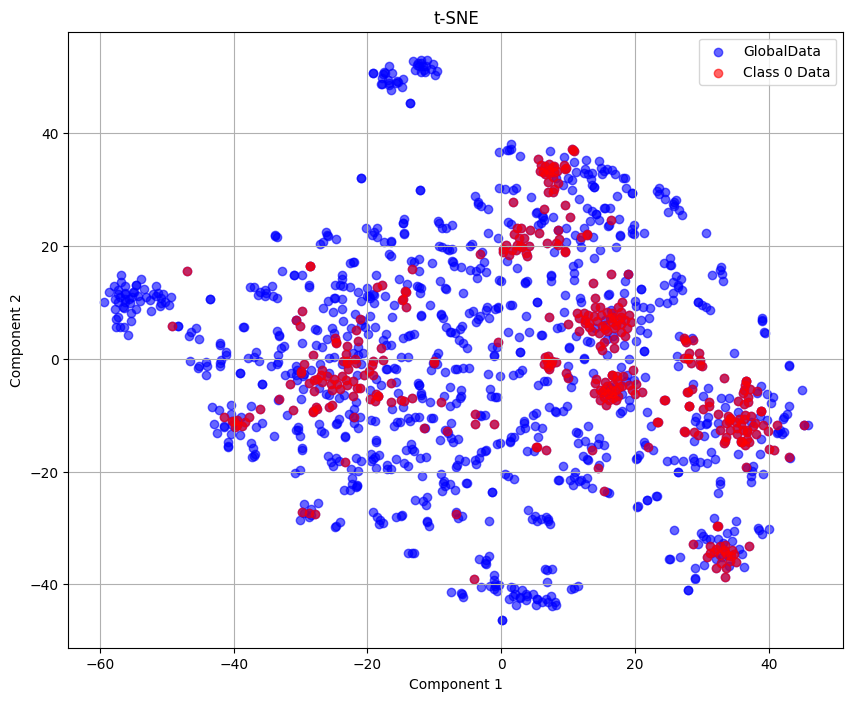

(1349,)
2 (36, 2) 1
372 408


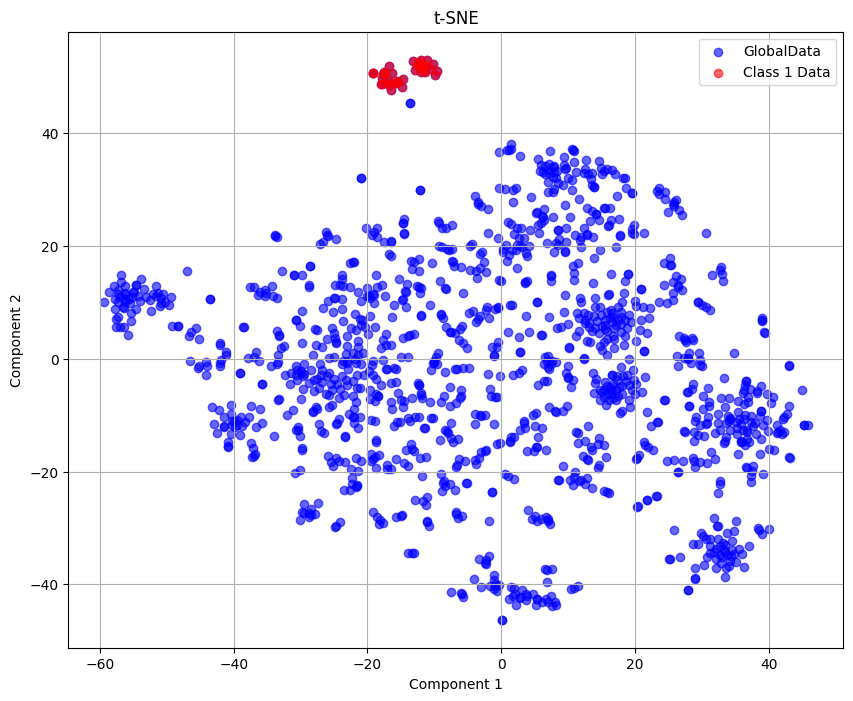

(1349,)
3 (60, 2) 2
408 468


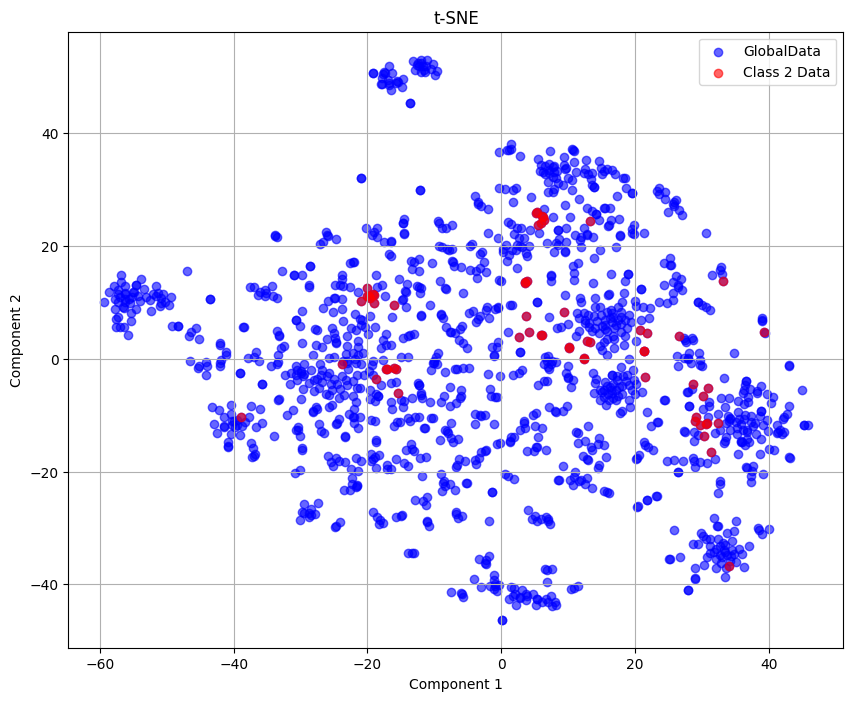

(1349,)
4 (188, 2) 3
468 656


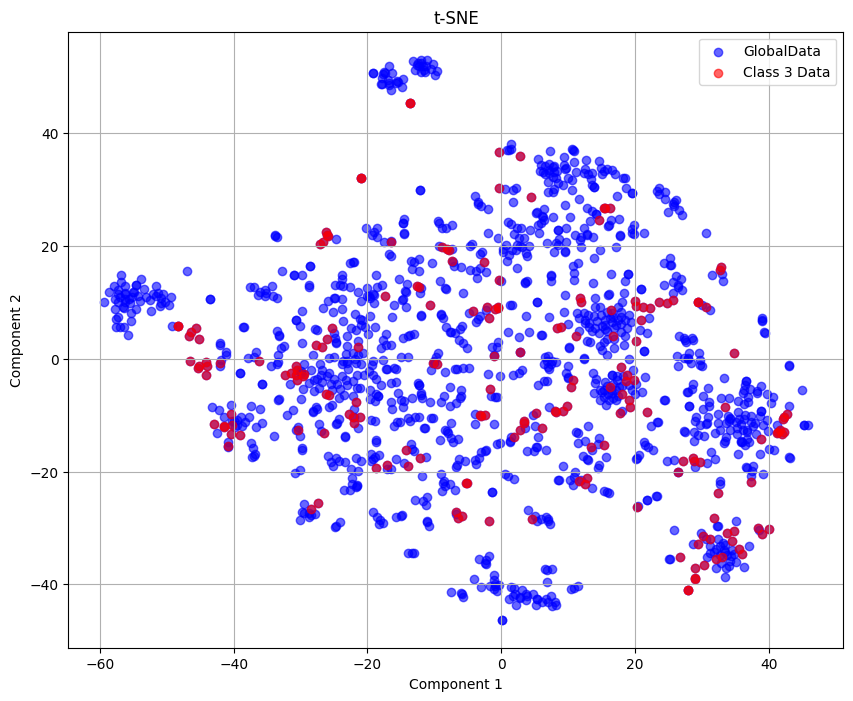

(1349,)
5 (396, 2) 4
656 1052


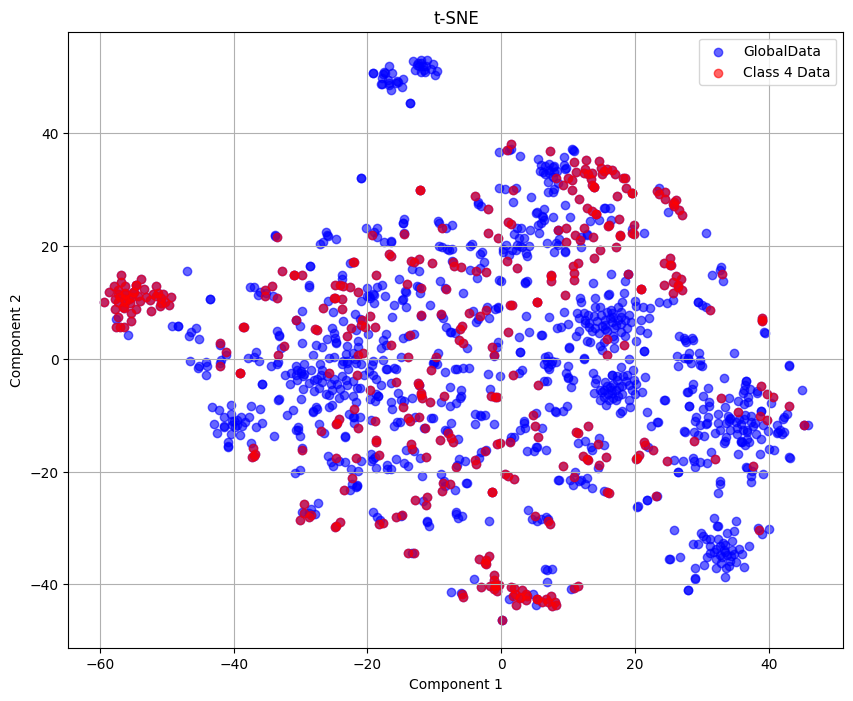

(1349,)
6 (297, 2) 5
1052 1349


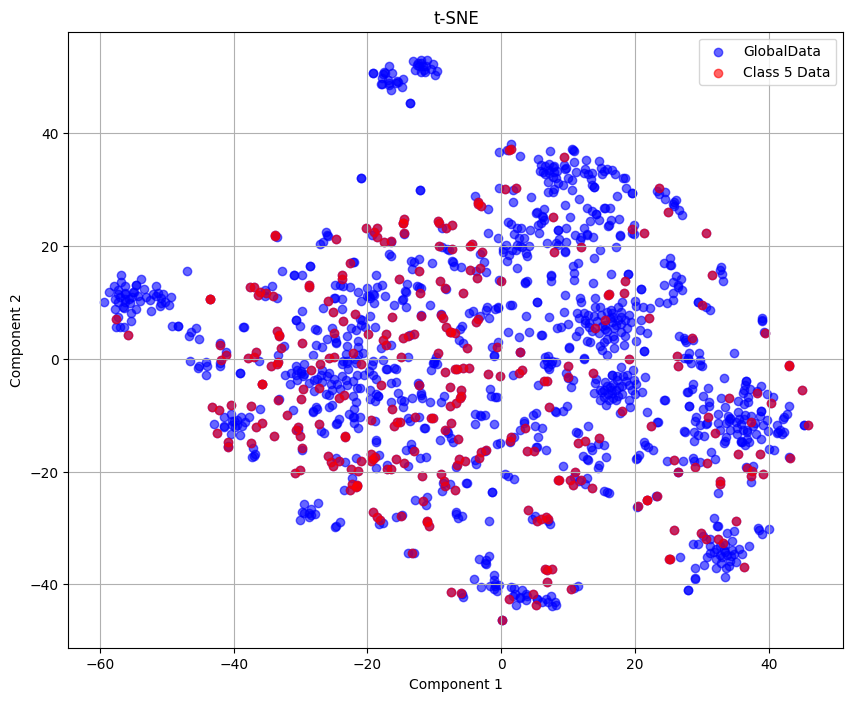

t-SNE Shape: (1349, 2)


In [ ]:

###############################################################################
###############################################################################
#                            Reduction Dimnesion Analysis
###############################################################################
#############################################################################
#__________________________________________________________________________
#         Plot Analysis Results for PCA and T-SNE
#__________________________________________________________________________
def plot_embeddings(data, data_clase = None, title = None, clase = 0):
    plt.figure(figsize=(10, 8))
    print(data[:, 0].shape)
    scatter = plt.scatter(data[:, 0], data[:, 1], c = 'b',
                          alpha=0.6, label = 'GlobalData')
    print(len(data_clase), data_clase[clase].shape, clase)
    #scatter = plt.scatter(data_clase[clase][:,0], data_clase[clase][:, 1], c = 'r',
                          #alpha=0.6, label  = ''.join(['Class ', str(clase), ' Data']))
    start_data = index_class[clase]
    end_data = index_class[clase+1]
    print(start_data, end_data)
    scatter = plt.scatter(data[start_data:end_data,0], data[start_data:end_data, 1], c = 'r',
                          alpha=0.6, label  = ''.join(['Class ', str(clase), ' Data']))
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.legend()
    plt.show()


#__________________________________________________________________________
#         PCA
#__________________________________________________________________________


print(' Performing PCA Analysis...')
pca = PCA(n_components = N_COMPONENTS,
          random_state = 42)

output_pca = pca.fit_transform(data_activa_flat)

output_clase_pca = []

for c in range(len(data_clase_flat)):
    output_clase_pca.append( pca.transform(data_clase_flat[c]) )
    plot_embeddings(output_pca,  output_clase_pca,  title = 'PCA', clase = c)

print('PCA Analysis Performed. Results PCA Shape:',output_pca.shape)

#__________________________________________________________________________
#         t-SNE
#__________________________________________________________________________
"""
t-SNE (t-Distributed Stochastic Neighbor Embedding) es una técnica de reducción
de dimensionalidad que se utiliza principalmente para visualizar datos de alta dimensión
en espacios de menor dimensión.

t-SNE busca preservar la estructura de los datos de alta dimensión en el espacio de menor dimensión.
 Intenta mantener los puntos similares (en alta dimensión) cerca unos de otros en el espacio reducido,
mientras que los puntos disímiles se separan.

Utiliza distancias de probabilidad para medir similitud.
Calcula la probabilidad de que un punto j sea un vecino de un punto i en el espacio de alta dimensión
usando una distribución Gaussiana centrada en ii. Luego, en el espacio de menor dimensión,
utiliza una distribución t-student (con grados de libertad bajos) para modelar la distancia entre puntos,
lo que ayuda a mantener la estructura local.

"""
print('Data Shape:',output_prediction.shape, ' Performing t-SNE Analysis...')

tsne = TSNE(n_components = N_COMPONENTS,
            perplexity   = PERPLEXITY,
            max_iter     = MAX_ITER,
            random_state = 42)

output_clase_tsne = []
output_tsne = tsne.fit_transform(data_activa_flat)

for c in range(len(data_clase_flat)):
    output_clase_tsne.append( tsne.fit_transform(data_clase_flat[c]) )
    plot_embeddings(output_tsne, output_clase_tsne, title = 't-SNE', clase = c)

print('t-SNE Shape:',output_tsne.shape)



## Clustering Analysis

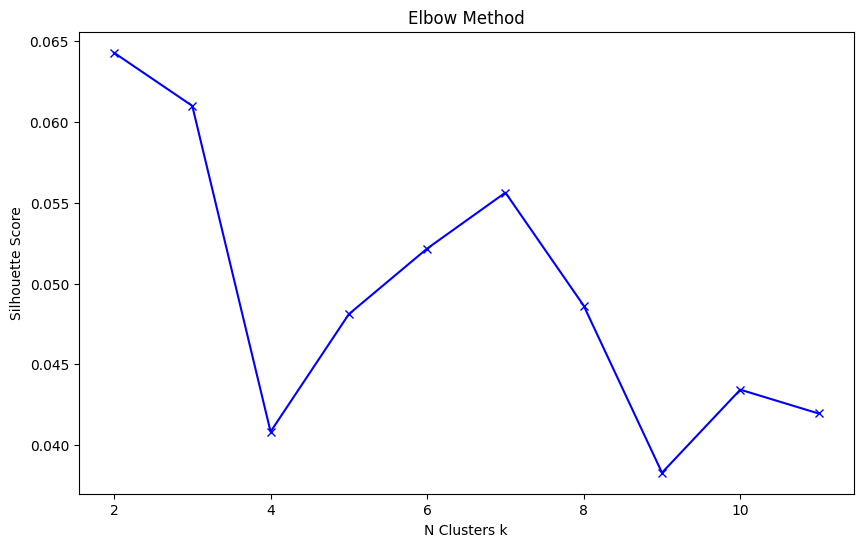

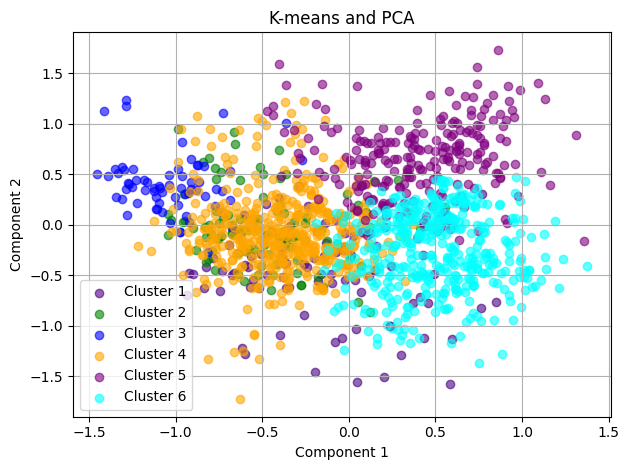

0 372 0
372 408 1
408 468 2
468 656 3
656 1052 4
1052 1349 5


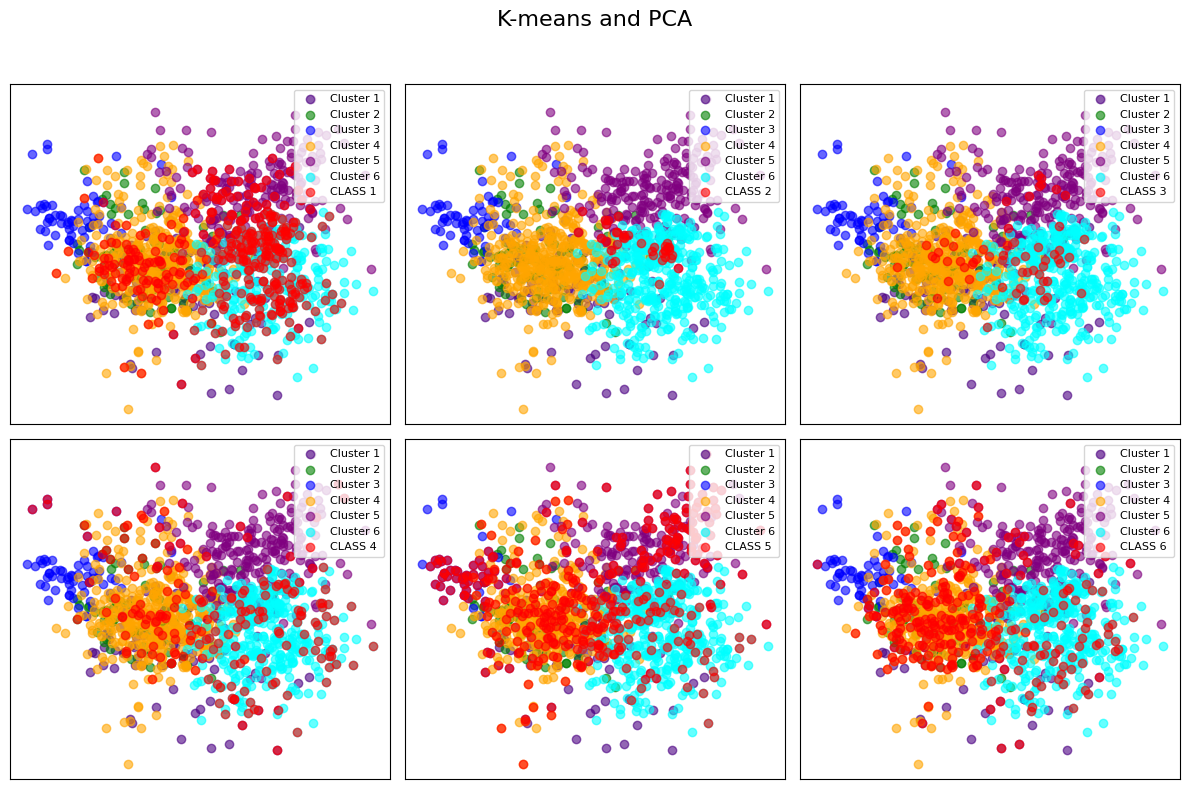

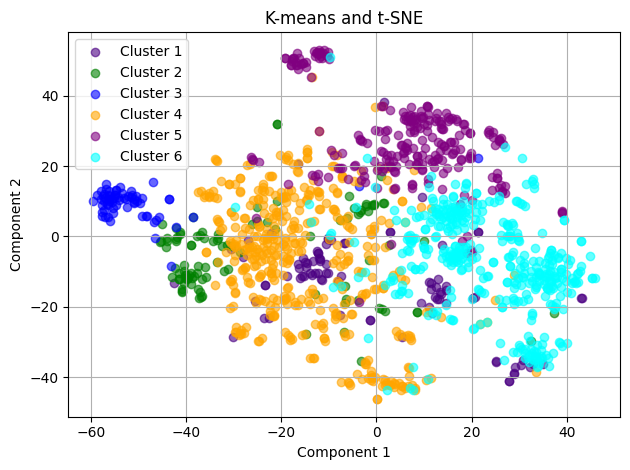

0 372 0
372 408 1
408 468 2
468 656 3
656 1052 4
1052 1349 5


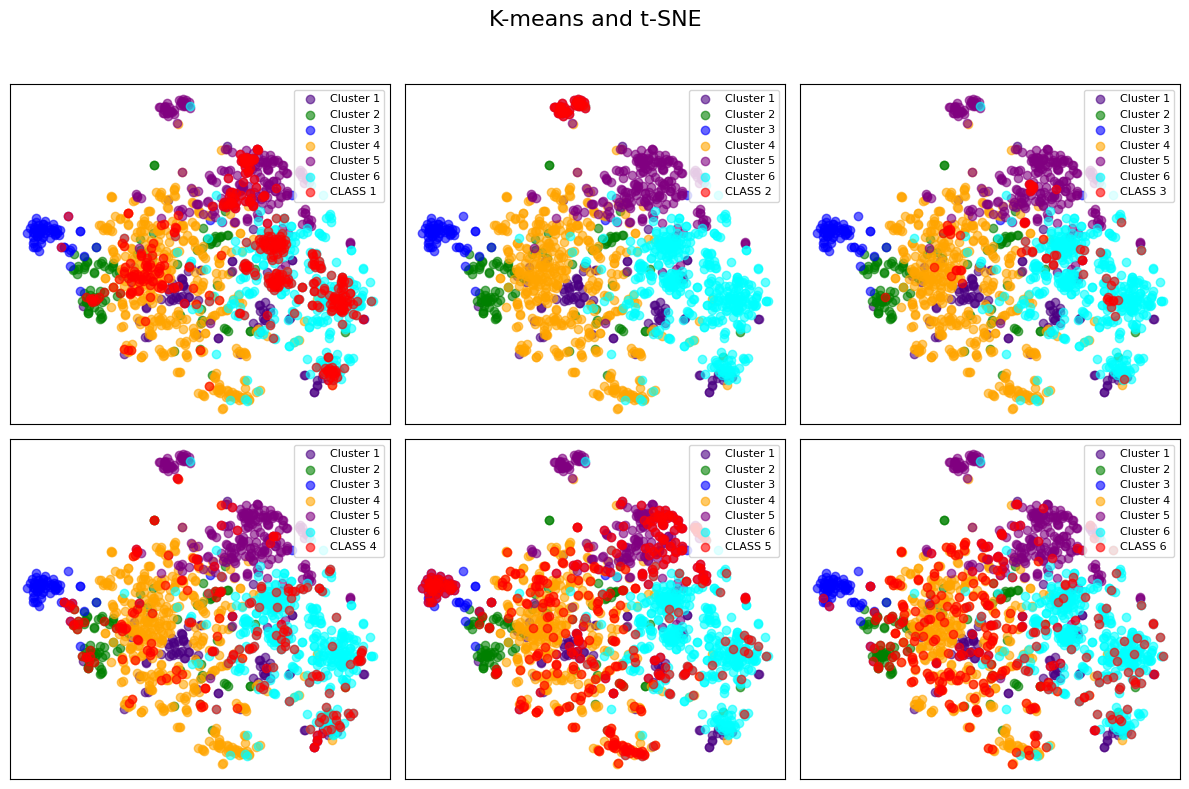

"\nfor c in range(n_classes):\n    output_clase_clusters.append( kmeans.predict(data_clase_flat[c]) )\n    plot_clusters(output_pca, output_clusters, 'K-means and PCA', classe = c)\nfor c in range(len(data_clase_flat)):\n    plot_clusters(output_tsne,output_clusters, 'K-means and t-SNE', classe = c)\n"

In [ ]:
###############################################################################
###############################################################################
#                            Clustering-Analysis
###############################################################################
###############################################################################
#__________________________________________________________________________
#           Plot Score vs N Components in k-Means Cluster Analysis
#__________________________________________________________________________
def plot_score(K, scores):
    plt.figure(figsize=(10, 6))
    plt.plot(K, scores, 'bx-')
    plt.xlabel('N Clusters k')
    plt.ylabel('Silhouette Score')
    plt.title('Elbow Method')
    plt.show()

#__________________________________________________________________________
#           Compute  Score vs N Components in k-Means Cluster Analysis
#__________________________________________________________________________
def get_scores(data, K_max):
    scores = []
    K = range(2, K_max)
    for k in K:
        kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
        kmeans.fit(data)
        score = silhouette_score(data, kmeans.labels_)
        scores.append(score)
    return K, scores

#__________________________________________________________________________
#    Plot t-SNE/PCA Data Representation with K-Means Cluster Agrupation
#__________________________________________________________________________
def plot_clusters(data,  clusters, title = None, classe=-1):
    colors = ['indigo', 'green', 'blue', 'orange', 'purple', 'cyan']
    cluster_names = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6']

    for i in range(6):
        points = data[clusters == i]

        scatter = plt.scatter(points[:, 0], points[:, 1],
                          c = colors[i], label = cluster_names[i], alpha=0.6)
    if classe>=0:
        start_data = index_class[classe]
        end_data = index_class[classe+1]
        print(start_data, end_data, classe)
        scatter = plt.scatter(data[start_data:end_data, 0], data[start_data:end_data, 1],
                              c = 'r', label = ''.join(['CLASS ', str(classe + 1)]) ,alpha=0.6)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if classe<0:
       fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))


       for i, ax in enumerate(axes.flat):
           for ic in range(6):
              points = data[clusters == ic]

              scatter = ax.scatter(points[:, 0], points[:, 1],
                          c = colors[ic], label = cluster_names[ic], alpha=0.6)

           start_data = index_class[i]
           end_data = index_class[i+1]
           print(start_data, end_data, i)
           scatter = ax.scatter(data[start_data:end_data, 0], data[start_data:end_data, 1],
                              c = 'r', label = ''.join(['CLASS ', str(i + 1)]) ,alpha=0.6)


           ax.set_xticks([])  # Eliminar ejes X
           ax.set_yticks([])
           ax.legend(loc='upper right', fontsize=8)
       fig.suptitle(title, fontsize=16)

       plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el layout para que el título y la leyenda no se solapen
       plt.show()
#__________________________________________________________________________
#     K-Means Clustering
#__________________________________________________________________________
K_max = 12
K, scores = get_scores(data_activa_flat, K_max)
plot_score(K, scores)

num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=42)
output_clusters = kmeans.fit_predict(data_activa_flat)

plot_clusters(output_pca, output_clusters, 'K-means and PCA')
plot_clusters(output_tsne,output_clusters, 'K-means and t-SNE')

#__________________________________________________________________________
#     K-Means  + t-SNE/PCA Representaion
#__________________________________________________________________________

output_clase_clusters = []
"""
for c in range(n_classes):
    output_clase_clusters.append( kmeans.predict(data_clase_flat[c]) )
    plot_clusters(output_pca, output_clusters, 'K-means and PCA', classe = c)
for c in range(len(data_clase_flat)):
    plot_clusters(output_tsne,output_clusters, 'K-means and t-SNE', classe = c)
"""


## Confidence Boxplot

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Clase 1  1349 non-null   float64
 1   Clase 2  1349 non-null   float64
 2   Clase 3  1349 non-null   float64
 3   Clase 4  1349 non-null   float64
 4   Clase 5  1349 non-null   float64
 5   Clase 6  1349 non-null   float64
dtypes: float64(6)
memory usage: 63.4 KB
None


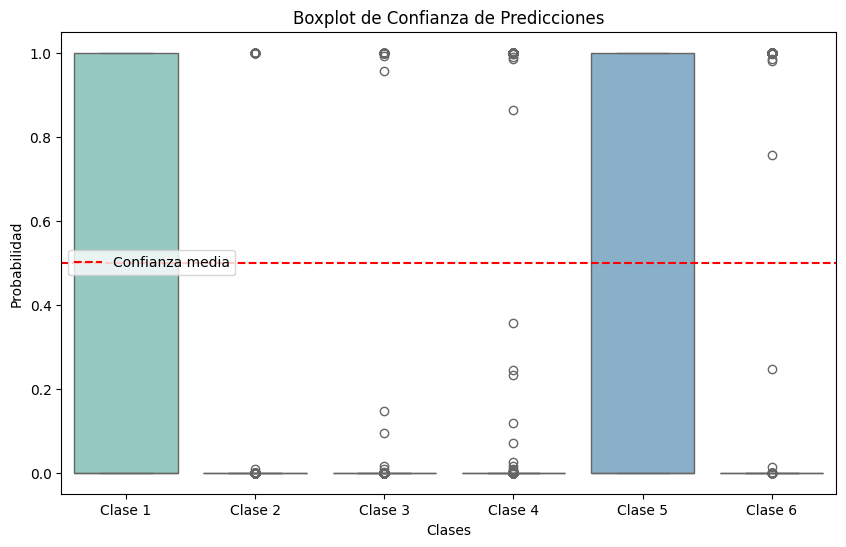

In [ ]:
###############################################################################
###############################################################################
#                  CONFIDENCE  BOXPLOT
###############################################################################
###############################################################################

#__________________________________________________________________________
#
#__________________________________________________________________________

def plot_BoxConfidence(data):
    # Crear el boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_box, palette="Set3")
    plt.title('Boxplot de Confianza de Predicciones')
    plt.ylabel('Probabilidad')
    plt.xlabel('Clases')
    #plt.ylim(0, 2)  # Las probabilidades están entre 0 y 1
    plt.axhline(0.5, color='red', linestyle='--', label='Confianza media')
    plt.legend()
    plt.show()

output_box = output_prediction/output_prediction.sum(axis=1, keepdims = True)

clases = range(6)
columns = [''.join(['Clase ',str(x + 1)]) for x in clases]
df_box = pd.DataFrame(output_box, columns = columns)
print(df_box.info())
plot_BoxConfidence(output_box)


## Confussion Matrix

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       372
           1       0.97      1.00      0.99        36
           2       0.96      0.92      0.94        60
           3       0.74      0.87      0.80       188
           4       0.91      0.86      0.88       396
           5       0.83      0.81      0.82       297

    accuracy                           0.86      1349
   macro avg       0.88      0.89      0.88      1349
weighted avg       0.86      0.86      0.86      1349


METRIC PERFORMANCE:
 --------------------------------------------------
	Accuracy: 	 0.8569310600444774
	Precision: 	 0.8572279432618288
	Recall: 	 0.8569310600444774
	F1_score: 	 0.856060685927257



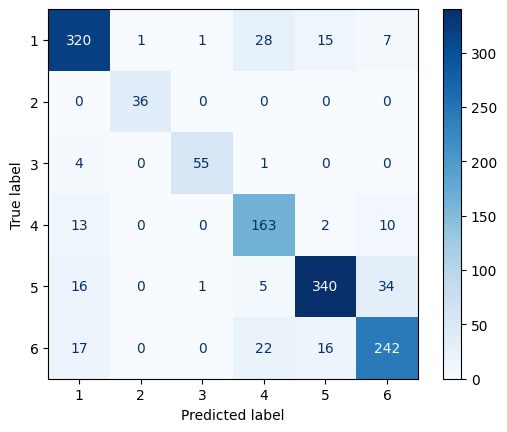

In [ ]:
###############################################################################
###############################################################################
#                CONFUSSION MATRIX
###############################################################################
###############################################################################
#__________________________________________________________________________
#
#__________________________________________________________________________

def plot_Results(target, label, clases):
    print(classification_report(target, label))
    conf_matrix = confusion_matrix(target, label)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels= [str(x+1) for x in range(clases)])
    disp.plot(cmap='Blues')

###############################################################################
#####   Target Aleatorio apra testear la matriz de confusion
if not TARGET:
    target_prediction = np.random.randint(0, n_classes, size = output_prediction.shape[0])
###############################################################################

labels = np.argmax(output_prediction, axis = 1)
plot_Results(target_prediction, labels, clases = 6)

accuracy  = accuracy_score(labels, target_prediction)
precision = precision_score(labels, target_prediction, average = 'weighted')
recall    = recall_score(labels, target_prediction, average = 'weighted')
f1        = f1_score(labels, target_prediction, average = 'weighted')

print('\nMETRIC PERFORMANCE:\n','-'*50)
print('\tAccuracy: \t', accuracy)
print('\tPrecision: \t', precision)
print('\tRecall: \t', recall)
print('\tF1_score: \t', f1)
print()

## Curva ROC

(1349,) (1349,)


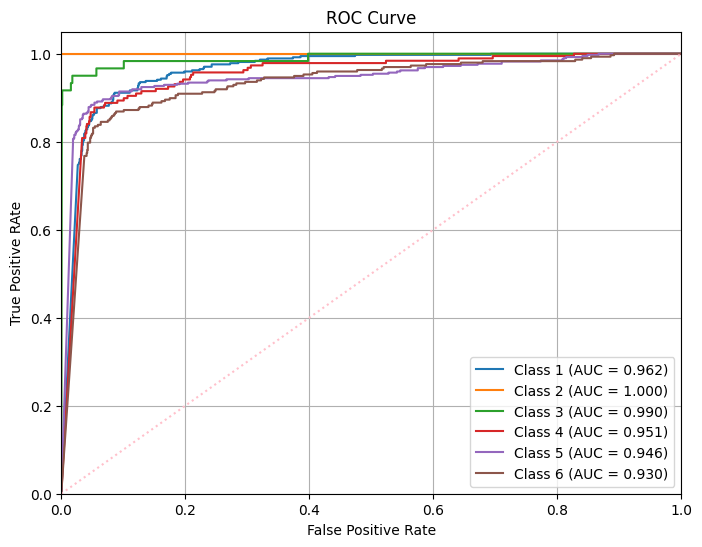

In [ ]:

# Graficar la curva ROC
def plot_CurvaRoc(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.3f})'.format(i+1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='pink', linestyle='dotted')  # Línea de referencia
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive RAte')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

target_binary = label_binarize(target_prediction, classes=[0, 1, 2,3,4,5])  # Cambia según tus clases
n_classes = target_binary.shape[1]

# Calcular AUC y ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_binary[:, i], output_prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print(target_prediction.shape, labels.shape)
# Calcular la curva ROC
#fpr, tpr, thresholds = roc_curve(target_prediction, labels)
#roc_auc = auc(fpr, tpr)
plot_CurvaRoc(fpr, tpr, roc_auc)


# **Machine Learning**

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        26
           1       0.53      0.69      0.60        36
           2       0.86      0.90      0.88        20
           3       0.84      0.75      0.79       143
           4       0.83      0.94      0.88        63
           5       0.91      0.87      0.89       117

    accuracy                           0.81       405
   macro avg       0.76      0.79      0.78       405
weighted avg       0.82      0.81      0.81       405

              precision    recall  f1-score   support

           0       0.41      0.69      0.51        26
           1       0.52      0.75      0.61        36
           2       0.82      0.90      0.86        20
           3       0.87      0.67      0.76       143
           4       0.82      0.95      0.88        63
           5       0.93      0.83      0.88       117

    accuracy                           0.78       405
   macro avg       0.73

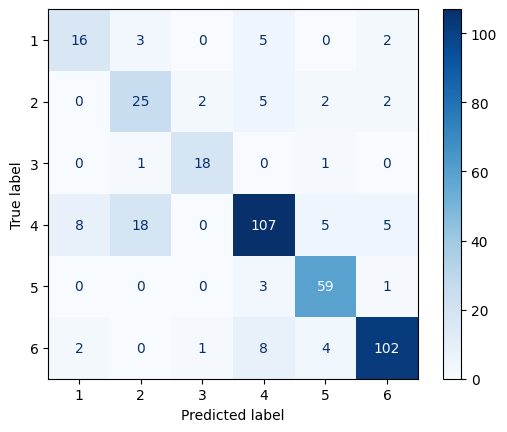

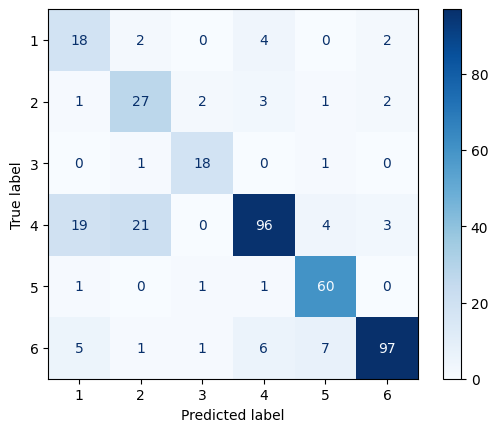

In [ ]:
###############################################################################
###############################################################################
#                            CLASIFICADOR MACHINE LEARNING
###############################################################################
###############################################################################
#__________________________________________________________________________
#
#__________________________________________________________________________
label = 'Cluster'       # 'Label' o 'Cluster'

if label == 'Label':
    clases = 2
if label == 'Cluster':
    clases = 6
#__________________________________________________________________________
#
#__________________________________________________________________________

def plot_Results(target, label, clases):
    print(classification_report(target, label))
    conf_matrix = confusion_matrix(target, label)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                  display_labels= [str(x+1) for x in range(clases)])
    disp.plot(cmap='Blues')


df_tsne = pd.DataFrame(output_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Cluster'] = output_clusters
df_tsne['Label'] = target_prediction

X_train, X_test, y_train, y_test = train_test_split(df_tsne[['TSNE1', 'TSNE2']],
                                                    df_tsne[label],
                                                    test_size=0.3,
                                                    random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
#__________________________________________________________________________
#
#__________________________________________________________________________
# RandomForest Classifier
###########################################################################
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

label_rf = rf_classifier.predict(X_test)
label_rf = np.array(label_rf )
plot_Results(y_test, label_rf, clases)


#__________________________________________________________________________
#
#__________________________________________________________________________
# K-Neighnors Classifier
###########################################################################
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

label_kn = knn_classifier.predict(X_test)
label_kn = np.array(label_kn )
plot_Results(y_test, label_kn, clases)

